In [1]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [2]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122405 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf

BASE_DIR = '/content/drive/MyDrive/Automatic Scene Description Generation/main/data'
WORKING_DIR = '/content/drive/MyDrive/Automatic Scene Description Generation/main'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ../../../

/


In [ ]:
!pwd

/


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 26s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# extract features from image
features = {}
directory =BASE_DIR +'/Images'
print(directory)
#directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

/content/drive/MyDrive/Automatic Scene Description Generation/main/data/Images


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
len(features)

8091

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
features['405051459_3b3a3ba5b3'][0].shape

(4096,)

In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
# before preprocess of text
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
# preprocess the text
clean(mapping)

In [16]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

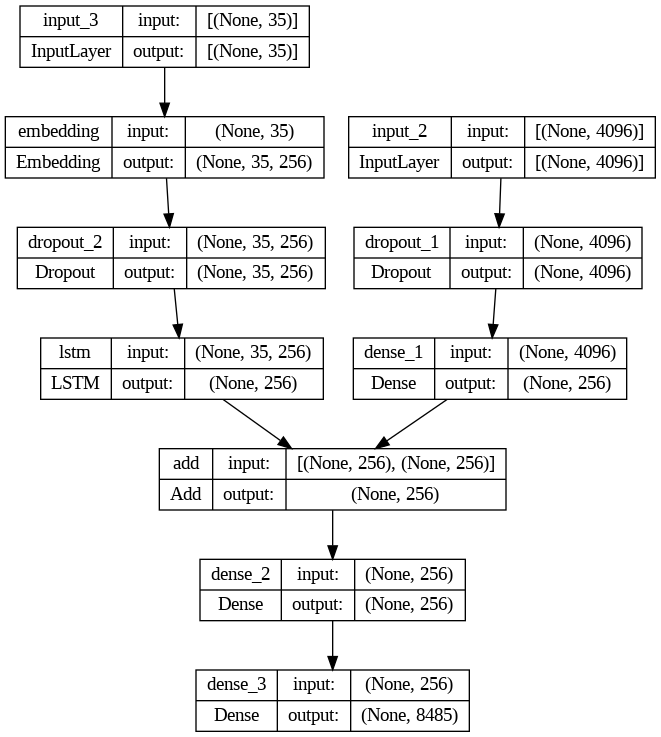

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 65s 285ms/step - loss: 2.0667


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [6]:
model = tf.keras.models.load_model(WORKING_DIR+'/best_model.h5')

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [7]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [8]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(final_model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.522663
BLEU-2: 0.298324


In [ ]:
len(actual)

810

In [ ]:
len(predicted)

810

In [ ]:
predicted[0]

['startseq',
 'man',
 'in',
 'red',
 'jacket',
 'is',
 'standing',
 'on',
 'ladder',
 'endseq']

In [ ]:
!pip  install sacrebleu

!pip3 install datasets

import datasets
from datasets import load_metric

In [ ]:
bleu=load_metric("bleu")
#predictions=[["I",'have','30','years']]
predictions = predicted
references = actual
bleu.compute(predictions=predictions,references=references)

<ipython-input-32-d568c77adc56>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu=load_metric("bleu")


{'bleu': 0.1005821881699049,
 'precisions': [0.5226633674502306,
  0.17027595594604628,
  0.06243982945949663,
  0.018418201516793065],
 'brevity_penalty': 1.0,
 'length_ratio': 1.3495749848208864,
 'translation_length': 8891,
 'reference_length': 6588}

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
      print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is playing with brown dog endseq


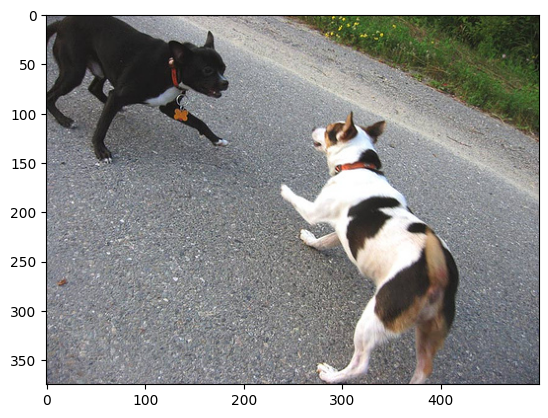

In [27]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq group of mountain bikers race each other down dirt hill endseq
startseq group of people do tricks on motorbikes endseq
startseq dirt bikers riding off jump endseq
startseq four motorcycle racers are on dirt track endseq
startseq four motorcycles are racing on dirt track endseq
--------------------Predicted--------------------
startseq man on bicycle jumping high in the air while watching the red hilly jump endseq


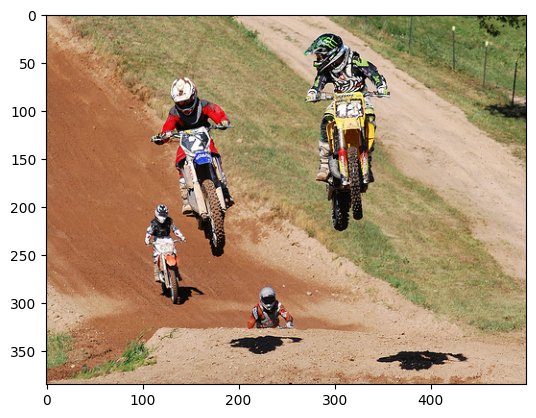

In [28]:
generate_caption("3717309680_e5105afa6d.jpg")

---------------------Actual---------------------
startseq "a black and brown dog runs along the sand avoiding an oncoming wave ." endseq
startseq dog is running parallel with the ocean waves endseq
startseq dog running in the surf endseq
startseq dog runs on the shore endseq
startseq the dog runs next to the crashing waves of the ocean endseq
--------------------Predicted--------------------
startseq black dog jumping through the water endseq


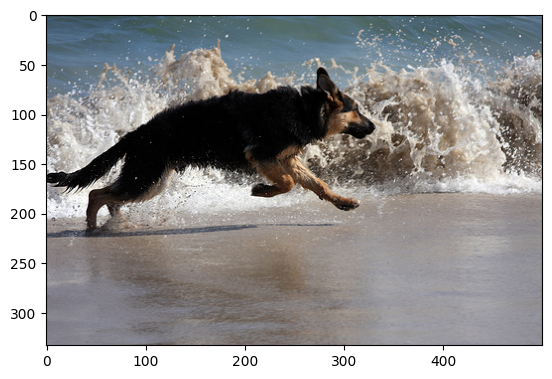

In [29]:
generate_caption("3704431444_f337ec2b90.jpg")

---------------------Actual---------------------
startseq girls fighting on karate competition endseq
startseq two girls are kicking each other in martial arts uniforms endseq
startseq two people are performing karate at tournament endseq
startseq two woman are doing karate endseq
startseq two women in their karate uniforms kick at one another endseq
--------------------Predicted--------------------
startseq two men kick kick kick kick endseq


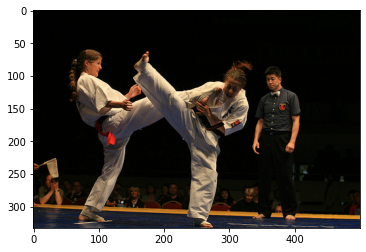

In [ ]:
generate_caption("3697456750_460aea7252.jpg")

---------------------Actual---------------------
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
--------------------Predicted--------------------
startseq two wheel drive car is driving on the hill endseq


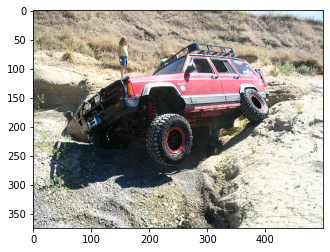

In [ ]:
generate_caption("36422830_55c844bc2d.jpg")

--------------------Predicted--------------------
startseq man in white vest playing guitar endseq


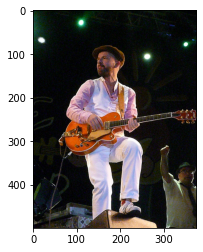

In [ ]:
generate_caption("3723690961_729dd5d617.jpg")

---------------------Actual---------------------
startseq civil war reenactment with cannon teams firing cannons endseq
startseq group of men firing an old fashion cannon endseq
startseq recreation of some battle endseq
startseq sveral men participating in civil war reenactment endseq
startseq war reenactors fire cannon endseq
--------------------Predicted--------------------
startseq man is riding the side of an intersection endseq


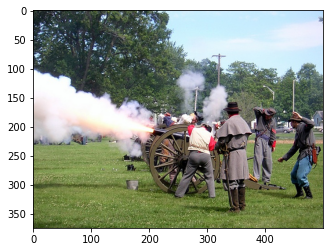

In [ ]:
generate_caption("61209225_8512e1dad5.jpg")

---------------------Actual---------------------
startseq group of people are sitting around campfire at night endseq
startseq group of people sitting on the grass by fire at nighttime endseq
startseq group of young people are sitting around fire pit endseq
startseq friends enjoy campfire endseq
startseq several people sitting around campfire endseq
--------------------Predicted--------------------
startseq two women are gathered around house endseq


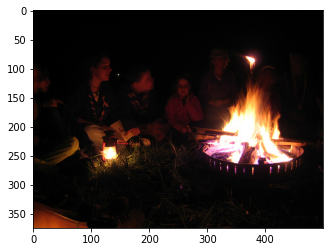

In [ ]:
generate_caption("69710411_2cf537f61f.jpg")

---------------------Actual---------------------
startseq woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain endseq
startseq woman in blue jacket rides brown pony near water endseq
startseq woman rides horse near frozen lake in the wintertime endseq
startseq young blond woman sitting atop brown draft horse in the snowy mountains endseq
startseq woman blue jacket sits on daft horse near frozen lake endseq
--------------------Predicted--------------------
startseq woman in blue jacket skiing down snowy mountain endseq


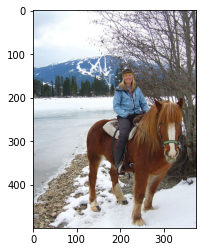

In [ ]:
generate_caption("109202756_b97fcdc62c.jpg")

---------------------Actual---------------------
startseq people on atvs and dirt bikes are traveling along worn path in field surrounded by trees endseq
startseq three people are riding around on atv 's and motorcycles endseq
startseq three people on motorbikes follow trail through dry grass endseq
startseq three people on two dirt-bikes and one four-wheeler are riding through brown grass endseq
startseq three people ride off-road bikes through field surrounded by trees endseq
--------------------Predicted--------------------
startseq two people are playing dirt atv through the woods endseq


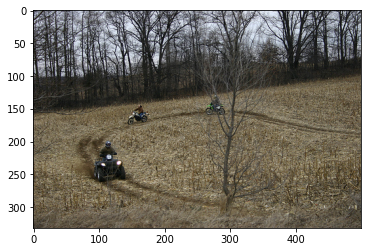

In [ ]:
generate_caption("112243673_fd68255217.jpg")

---------------------Actual---------------------
startseq boy and three girls in blue school uniforms walk down dirt-covered road endseq
startseq group of children in blue uniforms walk to class endseq
startseq four children in uniforms stand in front of palm trees endseq
startseq four teens in school uniforms walk down tropical road endseq
startseq group of school children in blue school uniforms endseq
--------------------Predicted--------------------
startseq group of people walk down path endseq


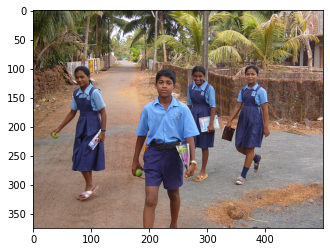

In [ ]:
generate_caption("146098876_0d99d7fb98.jpg")

---------------------Actual---------------------
startseq "a black station wagon with its lights on partially submerged in water with wooded area behind it ." endseq
startseq car is partially submerged in lake endseq
startseq car is sinking underwater in lake or river endseq
startseq toyota car drives into water endseq
startseq the four wheel drive car is driving through river endseq
--------------------Predicted--------------------
startseq man drives canoe through wooded area endseq


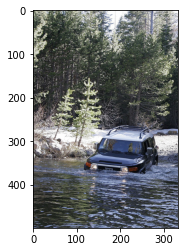

In [ ]:
generate_caption("160585932_fa6339f248.jpg")

In [ ]:
generate_caption("69710411_2cf537f61f.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

from PIL import Image
import matplotlib.pyplot as plt
def generate_caption_own_image(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_path=BASE_DIR + '/test/' + image_name
    # load image
    image = load_img(image_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # predict from the trained model
    cap = predict_caption(final_model, feature, tokenizer, max_length)
    image = Image.open(image_path)
    plt.imshow(image)
    print(cap+'\n')

startseq two men in red jerseys chasing soccer ball endseq



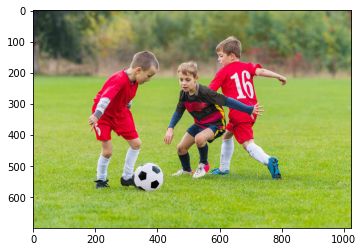

In [ ]:
generate_caption_own_image('football.jpeg')

startseq two people are sitting on the ground and one is wearing red jacket endseq



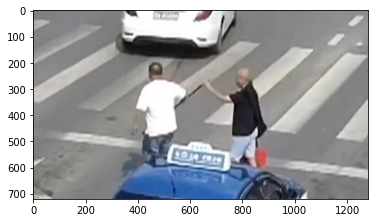

In [ ]:
generate_caption_own_image('blindperson.jpg')

startseq two guys are playing in field endseq



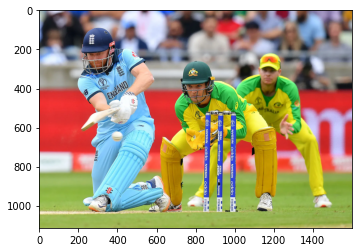

In [ ]:
generate_caption_own_image('cricket.jpg')

startseq man is standing on the side of large building with mural in the background endseq



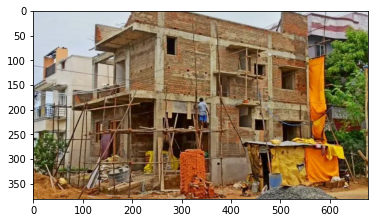

In [ ]:
generate_caption_own_image('construction.webp')

startseq woman wearing green jacket is sitting on couch with many people surrounding him endseq



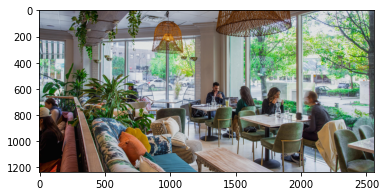

In [ ]:
generate_caption_own_image('coffeeshop.jpeg')

startseq man is standing on rocky mountain with fire in the background endseq



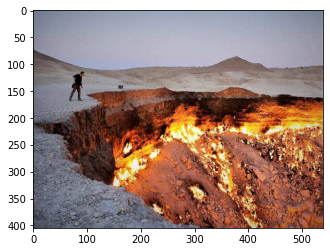

In [ ]:
generate_caption_own_image('dangerousplace.jpg')

startseq two brindle dogs are walking in the snow endseq



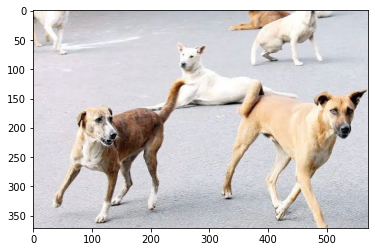

In [ ]:
generate_caption_own_image('dogs.jpg')

startseq the dog is sitting on the bench next to the wooden bench endseq



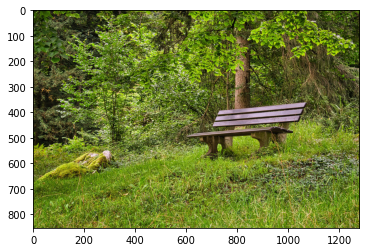

In [ ]:
generate_caption_own_image('woodenbench.jpg')